In [1]:
import os
import numpy as np
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn



from functools import partial

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm  # Import tqdm for progress bars

from mae_models import MaskedAutoencoderViT 

/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Using device: ", device)

Using device:  cuda


In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = (88,232)

In [4]:

class NumpyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get list of .npy file paths
        self.file_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".npy")]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        # Load the .npy file as a NumPy array
        image = np.load(file_path).astype(np.float32)  # Ensure it's float32 for PyTorch compatibility
        
        # If grayscale but missing channel dimension, add (C, H, W) format
        if image.ndim == 2:  
            image = np.expand_dims(image, axis=0)  # Convert (H, W) → (1, H, W)
        
        # Convert NumPy array to PyTorch tensor
        image = torch.from_numpy(image)
        # normalize to [0,1]
        image = image / torch.max(image)


        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image

In [5]:
# Define the image transformations (resize to 224x224)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    # normalize to [0, 1]
    
])

# Define paths for data directories
data_dir = "/home/alcindo/projeto/masked-autoencoders-cows/processed_data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

# Create dataset instances
train_dataset = NumpyDataset(root_dir=train_dir, transform=transform)
val_dataset =  NumpyDataset(root_dir=val_dir, transform=transform)

# Create DataLoaders with multi-processing and pinned memory for efficiency
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)



In [6]:
# Initialize the MAE model with in_channels=1 for grayscale images and send it to device
model = MaskedAutoencoderViT(
        patch_size=8, embed_dim=256, depth=12, num_heads=16, in_chans=1, img_size= IMAGE_SIZE,
        decoder_embed_dim=32, decoder_depth=4, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))


model = model.to(device)
# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [7]:
def split_images(images, patch_size):
    """
    Splits images into patches, handling rectangular images.
    
    images: Input tensor [B, C, H, W]
    patch_size: Size of the patch (square)

    Returns:
    patches: Tensor of patches [B, C, num_patches_h * num_patches_w, patch_size, patch_size]
    """
    # Image dimensions
    B, C, H, W = images.shape
    
    # Number of patches in each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Create patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(B, C, num_patches_h * num_patches_w, patch_size, patch_size)
    
    return patches, num_patches_h, num_patches_w

def apply_mask_to_patches(images, patches, masks, patch_size, num_patches_h, num_patches_w):
    """
    Applies a mask by replacing masked patches with a matrix of ones.

    images: Original tensor [B, C, H, W]
    patches: Tensor of patches [B, C, num_patches, patch_size, patch_size]
    masks: Mask tensor [B, num_patches] (0 to keep, 1 to mask)
    patch_size: Size of the patches
    num_patches_h, num_patches_w: Number of patches in height and width
    """
    B, C, num_patches, H, W = patches.shape  # Example: [128, 1, 196, 16, 16]
    masked_patches = patches.clone()
    ones_patch = torch.ones((C, patch_size, patch_size), device=patches.device)

    # Apply mask
    for b in range(masks.shape[0]):  # For each image in the batch
        for i in range(masks.shape[1]):  # For each patch
            if masks[b, i] == 1:
                masked_patches[b, :, i, :, :] = ones_patch  # Replace with ones

    # Reconstruct the masked images
    masked_images = masked_patches.view(B, C, num_patches_h, num_patches_w, patch_size, patch_size)
    masked_images = masked_images.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, images.shape[-2], images.shape[-1])

    return masked_images


def visualize_image(original, masked_image, recon_images):
    """
    Plots original, masked, and reconstructed images.
    """

    index = random.randint(0, original.shape[0]-1)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Original image
    axes[0].imshow(original[index, 0].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Masked image
    axes[1].imshow(masked_image[index, 0].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Masked")
    axes[1].axis("off")

    # Reconstructed image
    axes[2].imshow(recon_images[index, 0].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Reconstructed")
    axes[2].axis("off")

    plt.show()

Epoch [1/100] Train Loss: 0.84179292


Epoch [1/100] Validation Loss: 0.60291547


Epoch [2/100] Train Loss: 0.53284406


Epoch [2/100] Validation Loss: 0.46343744


Epoch [3/100] Train Loss: 0.42469599


Epoch [3/100] Validation Loss: 0.38692099


Epoch [4/100] Train Loss: 0.36433491


Epoch [4/100] Validation Loss: 0.34048875


Epoch [5/100] Train Loss: 0.32360332


Epoch [5/100] Validation Loss: 0.30624019


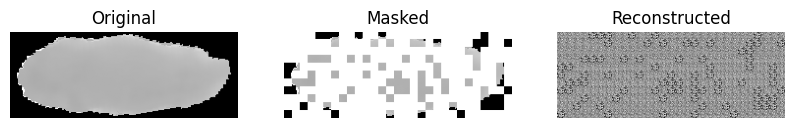

Epoch [6/100] Train Loss: 0.29301306


Epoch [6/100] Validation Loss: 0.28001891


Epoch [7/100] Train Loss: 0.26914719


Epoch [7/100] Validation Loss: 0.25813435


Epoch [8/100] Train Loss: 0.24879331


Epoch [8/100] Validation Loss: 0.23961826


Epoch [9/100] Train Loss: 0.23187997


Epoch [9/100] - Val:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:

# Training loop
num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Training loop with progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)
    for images in train_loop:
        images = images.to(device)  # Move images to GPU
        
        optimizer.zero_grad()
        loss, _, _ = model(images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.8f}")
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Val", leave=False)
    with torch.no_grad():
        for images in val_loop:
            images = images.to(device)
            loss, _, _ = model(images)
            val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.8f}")
    
    # plot each 5 epoch

    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            # select random batch
            images = next(iter(val_loader))
            images = images.to(device)

            _, pred, masks = model(images)

            # Split the images into patches
            patches, num_patches_h, num_patches_w = split_images(images, patch_size=8)

            masked_images = apply_mask_to_patches(images, patches, masks, patch_size = 8, num_patches_h = num_patches_h, num_patches_w = num_patches_w)

            # unpatch the pred
            recon_images = model.unpatchify(pred)

            visualize_image(images, masked_images, recon_images)
            

        
print("Training complete!")